In [1]:
%matplotlib notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

font_plt = {'family': 'serif','color':  'darkred','weight': 'normal','size': 8,}
font_plt_ax = {'family': 'serif','color':  'black','weight': 'normal', 'size': 8,}

import numpy as np #numerical python used for working with arrays, mathematical operations
import time #useful for timing functions
import sys
import os
import csv
import glob #glob is helpful for searching for filenames or directories
import ddm_clean as ddm #this is the module containing the differential dynamic microscopy code
import scipy #scientific python
from scipy.signal import blackmanharris as bh #for Blackman-Harris windowing
from scipy.optimize import leastsq
import pickle #for saving data

tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [60]:
root_directory = "D:\\Data\\Sylas\\2019-2020 XL Bead Analysis\\"

conditions = {"BothXL": "20_1_16_BothXL", "Entangled": "19_10_15_Entangled", 
              "CoXL": "20_1_14_CoXL", "ActinXL": "19_12_17_XLActin"}


In [62]:
print conditions.keys()

['ActinXL', 'Entangled', 'CoXL', 'BothXL']


In [5]:
file_matching = "\\DDM\\analysis\\*NormalizedISFFitting.p"

In [17]:
all_data = {}
for c in conditions.keys():
    pickle_files_to_load = glob.glob(root_directory+conditions[c]+file_matching)
    for i,filename in enumerate(pickle_files_to_load):
        f = open(filename,'rb') #open file for reading
        pickled_data = pickle.load(f) #load data from file
        f.close()
        
        #for each condition, initialize an emtpy dictionary
        # just want to initialize once
        if i==0:
            all_data[c] = {} #make sub-dictionary for this condition
            
        all_data[c][pickled_data['ROI']] = pickled_data

In [18]:
all_data.keys()

['ActinXL', 'Entangled', 'CoXL', 'BothXL']

In [22]:
all_data['CoXL'][0].keys()

['tau',
 'c',
 'last_times',
 'fps',
 'ROI',
 'Movie',
 'stretching_exponent',
 'qs',
 'times',
 'pixel_size',
 'data_directory',
 'alpha',
 'ISF',
 'k']

<IPython.core.display.Javascript object>


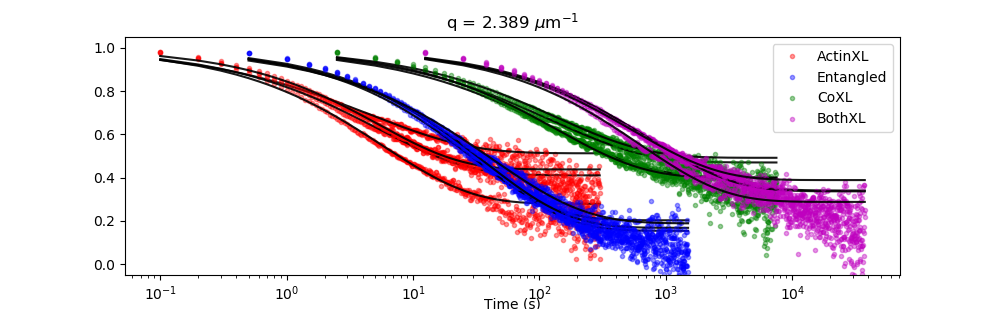

(-0.05, 1.05)

In [115]:
q_index = 35

fig = plt.figure(figsize=(5*2,5./1.618))
colors = ['r','b','g','m']
color_counter = 0
offset_yincrement = 0 #for shifting data sets from one another to better visualize
offset_xincrement = 5 #for shifting data in x to better visualize (1 for no shifting)
offset = 0
for condition_key in all_data:
    first_roi = True
    for roi_key in all_data[condition_key]:
        times = all_data[condition_key][roi_key]['times']
        qs = all_data[condition_key][roi_key]['qs']
        isf = all_data[condition_key][roi_key]['ISF']
        tau = all_data[condition_key][roi_key]['tau']
        c = all_data[condition_key][roi_key]['c']
        s = all_data[condition_key][roi_key]['stretching_exponent']
        theory = ddm.dTheoryNonErgISF(times, c[q_index], tau[q_index], s[q_index])
        offset_times = (offset_xincrement**offset)*times
        offset_y = offset*offset_yincrement
        if first_roi:
            plt.semilogx(offset_times, offset_y+isf[:,q_index],'.',c=colors[color_counter],label=condition_key,alpha=0.4)
        else:
            plt.semilogx(offset_times, offset_y+isf[:,q_index],'.',c=colors[color_counter],alpha=0.4)
        plt.semilogx(offset_times, offset_y+theory,'-k', alpha=0.9)
        first_roi=False
    color_counter += 1
    offset += 1
plt.xlabel("Time (s)", labelpad=-4)
plt.title("q = %.3f $\mu$m$^{-1}$" % qs[q_index])
plt.legend(loc=0)
plt.ylim(-0.05,1+offset_y+0.05)

In [24]:
isf.shape

(400L, 127L)

<IPython.core.display.Javascript object>


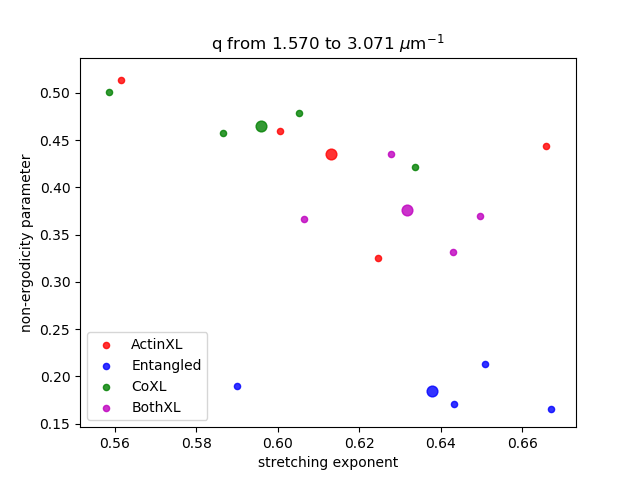

In [90]:
q_index = [23,45]

fig = plt.figure()
colors = ['r','b','g','m']
color_counter = 0
for condition_key in all_data:
    first_roi = True
    c_avg = 0
    s_avg = 0
    roi_count = 0
    for roi_key in all_data[condition_key]:
        times = all_data[condition_key][roi_key]['times']
        qs = all_data[condition_key][roi_key]['qs']
        isf = all_data[condition_key][roi_key]['ISF']
        tau = all_data[condition_key][roi_key]['tau']
        c = all_data[condition_key][roi_key]['c']
        s = all_data[condition_key][roi_key]['stretching_exponent']
        alpha = all_data[condition_key][roi_key]['alpha']
        k = all_data[condition_key][roi_key]['k']
        if isinstance(q_index,int):
            c_to_use = c[q_index]
            s_to_use = s[q_index]
        elif isinstance(q_index,list):
            c_to_use = c[q_index[0]:q_index[1]].mean()
            s_to_use = s[q_index[0]:q_index[1]].mean()
        else:
            c_to_use = 0; s_to_use = 0
            print("q_index not in the right form. int or list.")
        c_avg += c_to_use #for running average calculation
        s_avg += s_to_use #for running average calculation
        #theory = ddm.dTheoryNonErgISF(times, c[q_index], tau[q_index], s[q_index])
        if first_roi:
            plt.scatter(s_to_use, c_to_use, marker='o',c=colors[color_counter],label=condition_key,alpha=0.8,s=20)
        else:
            plt.scatter(s_to_use, c_to_use, marker='o',c=colors[color_counter],alpha=0.8,s=20)
        first_roi=False
        roi_count += 1
    plt.scatter(s_avg/roi_count, c_avg/roi_count,s=60,marker='o',c=colors[color_counter],alpha=0.8)
    color_counter += 1
plt.xlabel("stretching exponent")
plt.ylabel("non-ergodicity parameter")
if isinstance(q_index,int):
    plt.title("q = %.3f $\mu$m$^{-1}$" % qs[q_index])
elif isinstance(q_index, list):
    plt.title("q from %.3f to %.3f $\mu$m$^{-1}$" % (qs[q_index[0]],qs[q_index[1]]))
plt.legend(loc=0)

<IPython.core.display.Javascript object>


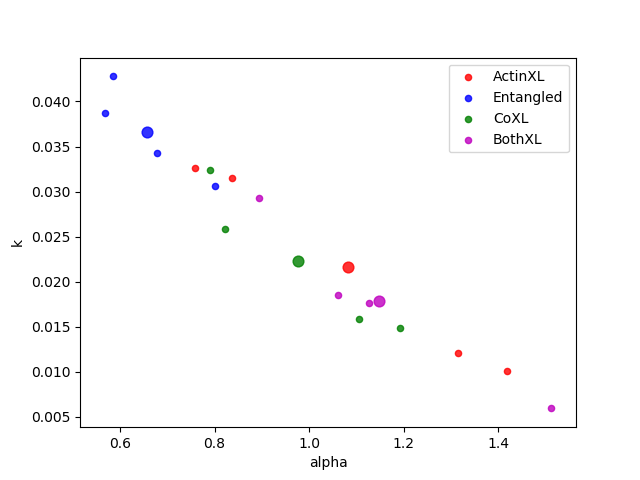

In [89]:
fig = plt.figure()
colors = ['r','b','g','m']
color_counter = 0
for condition_key in all_data:
    first_roi = True
    k_avg = 0
    alpha_avg = 0
    roi_count = 0
    for roi_key in all_data[condition_key]:
        times = all_data[condition_key][roi_key]['times']
        qs = all_data[condition_key][roi_key]['qs']
        isf = all_data[condition_key][roi_key]['ISF']
        tau = all_data[condition_key][roi_key]['tau']
        c = all_data[condition_key][roi_key]['c']
        s = all_data[condition_key][roi_key]['stretching_exponent']
        alpha = all_data[condition_key][roi_key]['alpha']
        k = all_data[condition_key][roi_key]['k']
        k_avg += k #for running average calculation
        alpha_avg += alpha #for running average calculation
        #theory = ddm.dTheoryNonErgISF(times, c[q_index], tau[q_index], s[q_index])
        if first_roi:
            plt.scatter(alpha, k,marker='o',c=colors[color_counter],label=condition_key,alpha=0.8,s=20)
        else:
            plt.scatter(alpha, k,marker='o',c=colors[color_counter],alpha=0.8,s=20)
        first_roi=False
        roi_count += 1
    plt.scatter(alpha_avg/roi_count, k_avg/roi_count,s=60,marker='o',c=colors[color_counter],alpha=0.8)
    color_counter += 1
plt.xlabel("alpha")
plt.ylabel("k")
plt.legend(loc=0)